In [5]:
!pip install -q gdown
!gdown --fuzzy 'https://drive.google.com/file/d/1CTh9T3yW1WYTwZRHPaVWLNH-uaD2Pn3Q/view?usp=drive_link'

Downloading...
From (original): https://drive.google.com/uc?id=1CTh9T3yW1WYTwZRHPaVWLNH-uaD2Pn3Q
From (redirected): https://drive.google.com/uc?id=1CTh9T3yW1WYTwZRHPaVWLNH-uaD2Pn3Q&confirm=t&uuid=ca343777-9d31-4f03-98e8-8caf76e55c00
To: /content/garbage-classification.zip
100% 86.0M/86.0M [00:01<00:00, 62.2MB/s]


In [16]:
!ls

'garbage classification'	       one-indexed-files-notrash_val.txt
'Garbage classification'	       one-indexed-files.txt
 garbage-classification.zip	       sample_data
 one-indexed-files-notrash_test.txt   'view?usp=drive_link'
 one-indexed-files-notrash_train.txt   zero-indexed-files.txt


In [7]:
import zipfile

with zipfile.ZipFile("garbage-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [9]:
!ls "/content"

'garbage classification'	       one-indexed-files-notrash_val.txt
'Garbage classification'	       one-indexed-files.txt
 garbage-classification.zip	       sample_data
 one-indexed-files-notrash_test.txt   'view?usp=drive_link'
 one-indexed-files-notrash_train.txt   zero-indexed-files.txt


In [11]:
!ls "/content/Garbage classification/Garbage classification"


cardboard  glass  metal  paper	plastic  trash


In [13]:
import os
import shutil

src = "/content/Garbage classification/Garbage classification"
dst = "/content/Garbage classification"

for folder in os.listdir(src):
    shutil.move(os.path.join(src, folder), dst)

shutil.rmtree(src)


In [14]:
!ls "/content/Garbage classification"

cardboard  glass  metal  paper	plastic  trash


In [17]:
data_dir = "/content/Garbage classification"


In [20]:
import os

for root, dirs, files in os.walk('/content'):
    print(root)
    for d in dirs:
        print(" └──", d)


/content
 └── .config
 └── Garbage classification
 └── garbage classification
 └── sample_data
/content/.config
 └── configurations
 └── logs
/content/.config/configurations
/content/.config/logs
 └── 2025.06.26
/content/.config/logs/2025.06.26
/content/Garbage classification
 └── cardboard
 └── glass
 └── plastic
 └── trash
 └── metal
 └── paper
/content/Garbage classification/cardboard
/content/Garbage classification/glass
/content/Garbage classification/plastic
/content/Garbage classification/trash
/content/Garbage classification/metal
/content/Garbage classification/paper
/content/garbage classification
 └── Garbage classification
/content/garbage classification/Garbage classification
 └── cardboard
 └── glass
 └── plastic
 └── trash
 └── metal
 └── paper
/content/garbage classification/Garbage classification/cardboard
/content/garbage classification/Garbage classification/glass
/content/garbage classification/Garbage classification/plastic
/content/garbage classification/Garbage c

In [21]:
data_dir = "/content/Garbage classification"
classes = os.listdir(data_dir)
print("Classes:", classes)


Classes: ['cardboard', 'glass', 'plastic', 'trash', 'metal', 'paper']


In [23]:
classes = os.listdir(data_dir)
print(classes)


['cardboard', 'glass', 'plastic', 'trash', 'metal', 'paper']


In [24]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_size = 224
images = []
labels = []

data_dir = "/content/Garbage classification"
classes = os.listdir(data_dir)
print("Classes:", classes)

for i, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_path):
        try:
            img = load_img(os.path.join(class_path, img_file), target_size=(img_size, img_size))
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(i)
        except Exception as e:
            print(f"Skipped {img_file} due to error: {e}")

print("Total images loaded:", len(images))


Classes: ['cardboard', 'glass', 'plastic', 'trash', 'metal', 'paper']
Total images loaded: 2527


In [27]:
from sklearn.model_selection import train_test_split

X = np.array(images)
y = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)


Train size: (2021, 224, 224, 3)
Validation size: (506, 224, 224, 3)


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, y_train, batch_size=32)
val_gen = val_datagen.flow(X_val, y_val, batch_size=32)


In [30]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetV2B2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,454 (33.02 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [31]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.1934 - loss: 1.7904 - val_accuracy: 0.2411 - val_loss: 1.6971
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.2185 - loss: 1.7560 - val_accuracy: 0.2213 - val_loss: 1.7027
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.2467 - loss: 1.7440 - val_accuracy: 0.3123 - val_loss: 1.6892
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.2226 - loss: 1.7441 - val_accuracy: 0.3024 - val_loss: 1.6939
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.2246 - loss: 1.7444 - val_accuracy: 0.2411 - val_loss: 1.6978
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.2361 - loss: 1.7482 - val_accuracy: 0.2549 - val_loss: 1.6889
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.2471 - loss: 1.7285 - val_accuracy: 0.2688 - val_loss: 1.6918
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.2530 - loss: 1.7293 - val_accuracy: 0.3063 - v

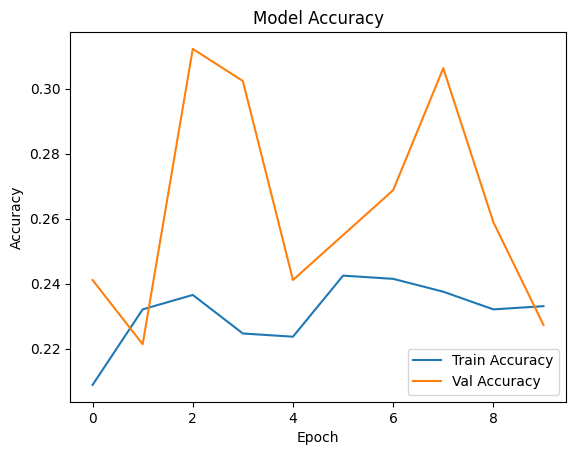

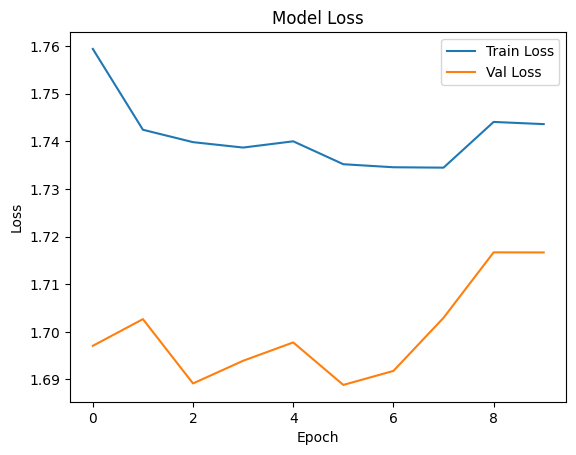

In [35]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
